Problem Statement- Given stock, income_statement, balance sheet, and cash flow data, we are looking to predict a company’s future earnings, or monthly performance based on given features

## Imports

In [32]:
#Import SKLearn Libraries
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler

#Import audio and plotting libraries
import librosa
import librosa.display
import soundfile
import wave
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from IPython.display import Audio as playback


#Directory packages
import os, glob, pickle
import time
from tqdm import tqdm

%matplotlib inline

#Set Default plot size
plt.rcParams['figure.figsize'] = (12, 8)



## Functions

In [57]:
def waveplot(file1, file2, title1, title2):
    '''This function creates a waveplot that shows the time and signal of each 
    data sample. Code adapted from Librosa documentation'''
    
    #Set Fig Size and load file
    fig, ax = plt.subplots(nrows=2, sharex=True)
    
    #Load waveform
    y, sr = librosa.load(file1)
    y_harm, y_perc = librosa.effects.hpss(y)
    librosa.display.waveshow(y_harm, sr=sr, ax = ax[0], alpha=0.5,  label='Harmonic')
    librosa.display.waveshow(y_perc, sr=sr, color='r', ax = ax[0], alpha=0.5,  label='Percussive')
    ax[0].set(title=title1)
    ax[0].label_outer()
    ax[0].set_ylabel('Amplitude')
    ax[0].legend()
    
    y, sr = librosa.load(file2)
    y_harm, y_perc = librosa.effects.hpss(y)
    librosa.display.waveshow(y_harm, sr=sr, ax = ax[1], alpha=0.5,  label='Harmonic')
    librosa.display.waveshow(y_perc, sr=sr, color='r', ax = ax[1], alpha=0.5,  label='Percussive')
    ax[1].set(title=title2)
    ax[1].label_outer()
    ax[1].set_ylabel('Amplitude')
    ax[1].legend()




In [34]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally

In [35]:
def noise_plot(file):
    y, sr = librosa.load(file)
    noise_volume = .050 * np.random.uniform() *np.amax(y)
    y = y + noise_volume*np.random.normal(size=y.shape[0])
    return y

In [36]:
def noise_augment():
    for folder in os.listdir('Data/Ravdess_Audio_data/'):
        for file in os.listdir(f'{"Data/Ravdess_Audio_data/"}{folder}'):
            
        # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
            X, sample_rate = librosa.load(f'{"Data/Ravdess_Audio_data/"}{folder}{"/"}{file}', res_type='kaiser_fast',duration=3,sr=44100)
            
            noise_volume = .050 * np.random.uniform() *np.amax(X)
            X = X + noise_volume*np.random.normal(size=X.shape[0])
               
            
            
            
            return X

## EDA

In [37]:
File_Sample = 'Data/All_Files/03-01-01-01-02-02-01.wav'

#### Elements of the data


**Here is what each number in the file segment "03-01-01-01-02-02-01" refers to:**

- Elements
    - **1st:  Modality** (03 = audio-only)
    - **2nd:  Vocal channel** (01 = speech)
    - **3rd:  Emotion** (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised)
    - **4th:  Emotional intensity** (01 = normal, 02 = strong). 
        - Note: There is no strong intensity for the 'neutral' emotion
    - **5th:  Statement** (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door")
    - **6th:  Repetition** (01 = 1st repetition, 02 = 2nd repetition)
    - **7th:  Actor** (01 to 24)
        - Odd numbered actors are male, even numbered actors are female


In [38]:
#Plays an audio file 

#Audio Text: "Dogs are sitting by the door"

from pydub import AudioSegment
from pydub.playback import play

sample = AudioSegment.from_wav('Data/All_Files/03-01-01-01-02-02-01.wav')

play(sample)

Our files are fairly short snippets, usually lasting a second or two long, where each actor changes tone, pitch, and inflection to carry a certain emotion. In the case below, the actor is displaying a neutral emotion with normal intensity, while the second file sample shows the same actor with an angry emotion 

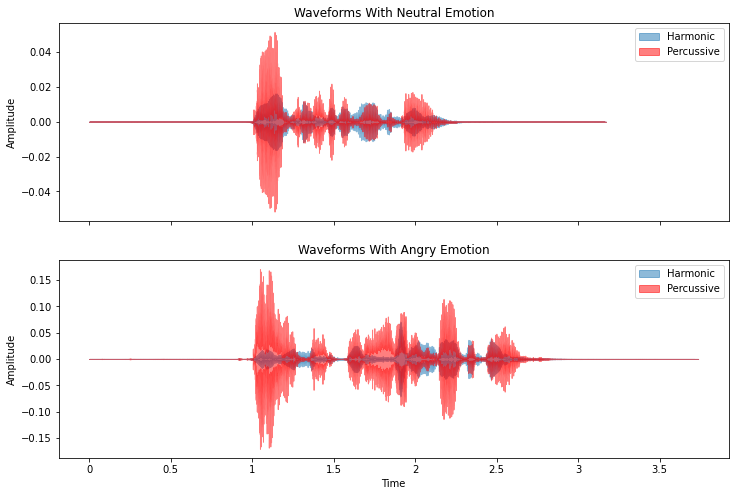

In [39]:
#Create a waveplot showing different emotion and standard time across all files
title2 = 'Data/All_Files/03-01-05-01-02-02-01.wav'

waveplot(File_Sample, title2, 'Waveforms With Neutral Emotion', 'Waveforms With Angry Emotion')

#Play Neutral Audio
playback(File_Sample)

In [40]:
#Same audio, but with Angry Emotion
playback(title2)

We will later augment the data via white noise, which is detailed below:

#### DataFrame

In [41]:
#Create Dictionaries used to map dataframe

emotions = {'01': 'Neutral', 
             '02': 'Calm', 
             '03': 'Happy',
             '04': 'Sad',
             '05': 'Angry',
             '06': 'Fearful',
             '07': 'Disgust',
             '08': 'Suprised'}


emot_dict = {'1': 'Neutral', 
             '2': 'Calm', 
             '3': 'Happy',
             '4': 'Sad',
             '5': 'Angry',
             '6': 'Fearful',
             '7': 'Disgust',
             '8': 'Suprised'}


iten_dict = {'1': 'Normal', 
             '2': 'Strong', 
             }

text_dict= {'1': "Kids are talking by the door", 
             '2': "Dogs are sitting by the door", 
             }


In [42]:
#Compile Dataframe based on features

df_fin = pd.DataFrame(columns = ['path', 'actor', 'emotion_id', 'intensity', 'stated_text', 'gender'])

#Compile Dataframe
start_time = time.time()

#Iterate through files
for folder in os.listdir('Data/Ravdess_Audio_data/'):
    for i in os.listdir(f'{"Data/Ravdess_Audio_data/"}{folder}'):
        
        #Append data to list
        path = []
        actor= []
        emotion_id= []
        intensity = []
        text = []
        gender = []
        path.append(i)
        actor.append(i[-6:-4])
        emotion_id.append(i[7])
        intensity.append(i[10:-13])
        text.append(i[13:14])
        if int(str(i[-5:-4])) % 2 == 0:
            gender.append('Female')
        else:
            gender.append('Male')
        
        #Append new data to dataframe
        df = pd.DataFrame(path, columns = ['path'])
        df = pd.concat([df, pd.DataFrame(actor, columns = ['actor'])], axis = 1)
        df = pd.concat([df, pd.DataFrame(emotion_id, columns = ['emotion_id'])], axis = 1)
        df = pd.concat([df, pd.DataFrame(intensity, columns = ['intensity'])], axis = 1)
        df = pd.concat([df, pd.DataFrame(text, columns = ['stated_text'])], axis = 1)
        df = pd.concat([df, pd.DataFrame(gender, columns = ['gender'])], axis = 1)
        df_fin = df_fin.append(df)

        #Show calculation time        
print("- DataFrame Complete. Loading time: %s seconds -" % round((time.time() - start_time), 2))

- DataFrame Complete. Loading time: 2.61 seconds -


In [43]:
#Map to Dictionaries
df_fin['source'] = 'RAVDESS'
df_fin['emotion'] = df_fin['emotion_id'].map(emot_dict)
df_fin['intensity'] = df_fin['intensity'].map(iten_dict)
df_fin['stated_text'] = df_fin['stated_text'].map(text_dict)


In [44]:
#Encode label for modeling purposes
df_fin['label']= df_fin['emotion']

target_encoder = LabelEncoder()
df_fin['encoded_label'] = target_encoder.fit_transform(df_fin['label'])

df_fin.head(2)

,path,actor,emotion_id,intensity,stated_text,gender,source,emotion,label,encoded_label
0,03-01-05-01-02-01-16.wav,16,5,Normal,Dogs are sitting by the door,Female,RAVDESS,Angry,Angry,0
0,03-01-06-01-02-02-16.wav,16,6,Normal,Dogs are sitting by the door,Female,RAVDESS,Fearful,Fearful,3


/Users/nathanmckinney/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


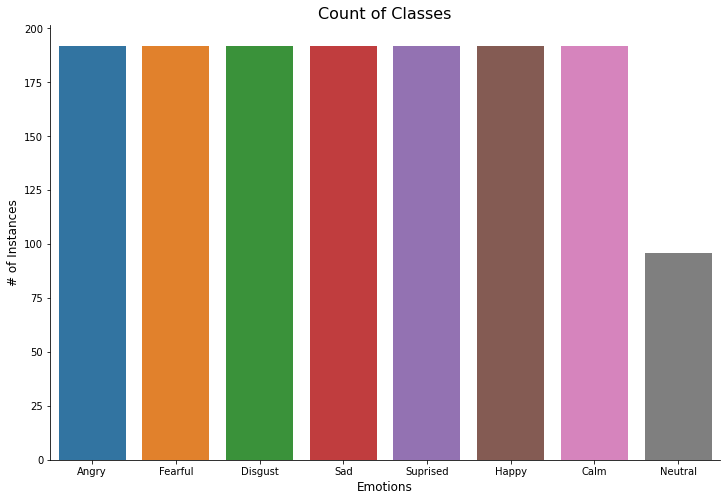

In [45]:
#EDA off database
sns.countplot(df_fin['emotion'])
plt.title('Count of Classes', size=16)

plt.xlabel('Emotions', size=12)
plt.ylabel('# of Instances', size=12)

sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()


Above shows the count of our features. All emotions with the exception of 'Neutral' are balanced. Below, our shape indicates 1440 files within our dataset.

In [46]:
df_fin.shape

(1440, 10)

In [47]:
#Genders are balanced
df_fin['gender'].value_counts()

Female    720
Male      720
Name: gender, dtype: int64

## Null Model

Given we have 8 emotions we are choosing from, the probability of correctly guessing one, without replacement, is about 13%. 
This will be our null score we will look to baseline model improvements off of.

## Audio Extraction

As we are looking to build a model for audio classification, we look extract several audio features. Our baseline will only use MFCC, While we will use additional features later on to see if it improves on our model's accuracy. Modeling will be done using Google Collab due to complications with TensorFlow and the M1 chip (Apple)

- **MFCC (Mel-Frequency Cepstral Coefficients):** 
    - MFCC, features represent phonemes (distinct units of sound) coming off of the vocal tract
- **MEL Spectrogram** 
    - The MEL scale is a scale that relates the perceived frequency of a tone to the actual measured frequency. If we were to look at, say, a land-line dial up, the mel scale would measure the distance between these sounds. The word mel comes from "melody".
    
- **Chroma**
    - The chroma
    is a powerful measurement of pitch, differentiating between 12 classes of pitch
    

#### **Baseline Extraction - MFCC**

In [48]:
data = pd.DataFrame(columns=['feature'])

#Compile Dataframe
start_time = time.time()

for folder in os.listdir('Data/Ravdess_Audio_data/'):
    for file in os.listdir(f'{"Data/Ravdess_Audio_data/"}{folder}'):
        
        X, sample_rate = librosa.load(f'{"Data/Ravdess_Audio_data/"}{folder}{"/"}{file}', res_type='kaiser_fast',duration=2.5,sr=22050*2, offset = 0.5)
        result=np.array([])
        
        #MFCC
        mfccs=np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13).T,axis=0)
        result=np.hstack((result, mfccs)) # stacking horizontally
        #result = mfccs
        
        
        data.loc[file] = [result]
        
        
        mfcc_data = pd.DataFrame(data['feature'].values.tolist())
        mfcc_data = pd.concat([mfcc_data], axis=1)

        #Show calculation time        
print("- DataFrame Complete. Loading time: %s seconds -" % round((time.time() - start_time), 2))

- DataFrame Complete. Loading time: 56.5 seconds -


In [49]:
mfcc_data.shape

df_mfcc = df_fin.reset_index()

df_mfcc = pd.concat([df_mfcc, mfcc_data], axis=1).reset_index()

df_mfcc.drop(columns = ['index', 'level_0'], inplace=True)

df_mfcc.head(1)

,path,actor,emotion_id,intensity,stated_text,gender,source,emotion,label,encoded_label,...,30,31,32,33,34,35,36,37,38,39
0,03-01-05-01-02-01-16.wav,16,5,Normal,Dogs are sitting by the door,Female,RAVDESS,Angry,Angry,0,...,5.209196,4.537996,-0.414414,0.797136,-0.006604,3.335797,0.98498,2.204353,-0.964435,2.174475


In [50]:
df_mfcc.to_csv('Data/DataFrames/MFCC_Data.csv', index = False, header=True)

#### **Multi_variable Extraction - MFCC, ZCR, Chroma, Mel_Spectogram**

In [51]:

data = pd.DataFrame(columns=['feature'])

#Compile Dataframe
start_time = time.time()

for folder in os.listdir('Data/Ravdess_Audio_data/'):
    for file in os.listdir(f'{"Data/Ravdess_Audio_data/"}{folder}'):
        
        X, sample_rate = librosa.load(f'{"Data/Ravdess_Audio_data/"}{folder}{"/"}{file}', res_type='kaiser_fast',duration=2.5,sr=22050*2, offset = 0.5)
        result=np.array([])
        
        # ZCR
        zcr = np.mean(librosa.feature.zero_crossing_rate(y=X).T, axis=0)
        result=np.hstack((result, zcr)) # stacking horizontally
     
        #MFCC
        mfccs=np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13).T,axis=0)
        result=np.hstack((result, mfccs)) # stacking horizontally
        #result = mfccs
            
         #Chroma
        stft=np.abs(librosa.stft(X))
        chroma=np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
        result=np.hstack((result, chroma)) # stacking horizontally
            
        #Mel Spectrogram
        mel=np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
        result=np.hstack((result, mel)) # stacking horizontally
        
        
        
        
        data.loc[file] = [result]
        
        
        final_data = pd.DataFrame(data['feature'].values.tolist())
        final_data = pd.concat([final_data], axis=1)

        #Show calculation time        
print("- DataFrame Complete. Loading time: %s seconds -" % round((time.time() - start_time), 2))

- DataFrame Complete. Loading time: 97.7 seconds -


In [52]:
final_data.head(1)

,0,1,2,3,4,5,6,7,8,9,...,171,172,173,174,175,176,177,178,179,180
0,0.147776,-492.303162,48.244617,-11.563274,8.428556,-18.633396,-3.536547,-16.64679,-10.850655,-19.68545,...,0.009121,0.004178,0.00195,0.001536,0.000905,0.000521,0.000219,0.00005,0.000016,8.843612e-07


In [53]:
df_fin = df_fin.reset_index()

df_fin = pd.concat([df_fin, final_data], axis=1).reset_index()

df_fin.drop(columns = ['index', 'level_0'], inplace=True)

df_fin.head(2)

,path,actor,emotion_id,intensity,stated_text,gender,source,emotion,label,encoded_label,...,171,172,173,174,175,176,177,178,179,180
0,03-01-05-01-02-01-16.wav,16,5,Normal,Dogs are sitting by the door,Female,RAVDESS,Angry,Angry,0,...,0.009121,0.004178,0.001950,0.001536,0.000905,0.000521,0.000219,0.000050,0.000016,8.843612e-07
1,03-01-06-01-02-02-16.wav,16,6,Normal,Dogs are sitting by the door,Female,RAVDESS,Fearful,Fearful,3,...,0.002589,0.001590,0.001378,0.001258,0.000637,0.000272,0.000092,0.000026,0.000005,4.393682e-07


In [54]:
df_fin.to_csv('Data/DataFrames/RAVDESS_Data.csv', index = False, header=True)

In [55]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    

    
    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically
    
    return result

In [56]:
#def Feature_df(data)

extract_features()

final_data

TypeError: extract_features() missing 1 required positional argument: 'data'

In [ ]:

for folder in os.listdir('Data/Ravdess_Audio_data/'):
        for file in os.listdir(f'{"Data/Ravdess_Audio_data/"}{folder}'):
            
        # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
            X, sample_rate = librosa.load(f'{"Data/Ravdess_Audio_data/"}{folder}{"/"}{file}', res_type='kaiser_fast',duration=3,sr=22050)
    
            # without augmentation
            res1 = result
            ress = np.array(res1)
    
            # data with noise
        
            #noise_data = noise_augment()
            #res2 = extract_features(noise_data)
            #result = np.vstack((ress, res2)) # stacking vertically
    
            # data with stretching and pitching
            #new_data = stretch(y)
            #data_stretch_pitch = pitch(new_data, sample_rate)
            #res3 = extract_features(data_stretch_pitch)
            #result = np.vstack((result, res3)) # stacking vertically

In [ ]:
X, y = [], []
for path, emotion in zip(data_path.Path, data_path.Emotions):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)

In [ ]:
def get_features():
    for folder in os.listdir('Data/Ravdess_Audio_data/'):
        for file in os.listdir(f'{"Data/Ravdess_Audio_data/"}{folder}'):
        # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
            X, sample_rate = librosa.load(f'{"Data/Ravdess_Audio_data/"}{folder}{"/"}{file}', res_type='kaiser_fast',duration=3,sr=22050)
    
            # without augmentation
            res1 = extract_features(X)
            result = np.array(res1)
    
            # data with noise
            noise_data = noise(X)
            res2 = extract_features(noise_data)
            result = np.vstack((result, res2)) # stacking vertically
    
            # data with stretching and pitching
            #new_data = stretch(y)
            #data_stretch_pitch = pitch(new_data, sample_rate)
            #res3 = extract_features(data_stretch_pitch)
            #result = np.vstack((result, res3)) # stacking vertically
    
    return result

In [ ]:
def Feature_Extract():
    data = pd.DataFrame(columns=['feature'])
    label = pd.DataFrame(columns=['label'])
    name = pd.DataFrame(columns=['name'])

    
    for folder in os.listdir('Data/Ravdess_Audio_data/'):
        for file in os.listdir(f'{"Data/Ravdess_Audio_data/"}{folder}'):
            X, sample_rate = librosa.load(f'{"Data/Ravdess_Audio_data/"}{folder}{"/"}{file}', res_type='kaiser_fast',duration=3,sr=22050)
            result=np.array([])
        
            # ZCR
            zcr = np.mean(librosa.feature.zero_crossing_rate(y=X).T, axis=0)
            result=np.hstack((result, zcr)) # stacking horizontally
     
            #MFCC
            mfccs=np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0)
            result=np.hstack((result, mfccs)) # stacking horizontally
            #result = mfccs
            
            #Chroma
            stft=np.abs(librosa.stft(X))
            chroma=np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
            result=np.hstack((result, chroma)) # stacking horizontally
            
            #Mel Spectrogram
            mel=np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
            result=np.hstack((result, mel)) # stacking horizontally
        
    #final_data = pd.DataFrame(data['feature'].values.tolist())
    #final_data = pd.concat([final_data,label,name], axis=1)

        return result

Calculate MFCC's for a given audio sample
@Slice the signal into short frames
compute periodogram estimate of power spectrum
Apply filterbank